In [1]:
import NetworkParameter as npm
import NetworkPrep as nwp
import SimulateParameterICE as spice
from SearchParameter import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors, patches
import matplotlib.colors as clr
import contextily as cx
from itertools import cycle
import warnings
import pickle
import rioxarray 
import xarray
from sigfig import round
import os
from pysal.explore import esda
from pysal.lib import weights
from esda.moran import Moran
from scipy.optimize import leastsq
from sklearn.linear_model import LinearRegression
from libpysal.weights.contiguity import Queen
from libpysal import examples
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import plot_local_autocorrelation
from splot._viz_utils import mask_local_auto, moran_hot_cold_spots, splot_colors
from scipy.interpolate import griddata
import powerlaw

warnings.filterwarnings('ignore')
plt.style.use("seaborn-white")
sns.set_style('ticks')
color_platte = ['#00429d', '#93c4d2', 'orange', '#93003a']

1. Note S3: Forecast Considering 'Switching Back to Internal Combustion Engines (ICE)'

In [2]:
def genToy(gamma, people_per_node, county, pq):
    n_rep = 5; year = 50
    DATA_PATH = os.path.join('..', 'data', state)

    demo = pd.read_csv(os.path.join(DATA_PATH, county, 'demo_data.csv'))
    number_node = int(demo.POPULATION.sum()/people_per_node); par = [-1, gamma, 3, 3, 0, 0,'None']
    G = NetworkCreators(0,par+[number_node,state,county])
    G.build_network()

    for j in range(n_rep):
        simulation_paras = {"p_value": pq['p'],
                            "q_value": pq['q'],
                            'return_prob':pq['return_prob'],
                            'return_year':pq['return_year'],
                            }
        
        func_name = 'ice'+'_'+str(gamma)+'_'+str(people_per_node)+'_'+str(pq['return_prob'])+'_'+str(pq['return_year'])
        RESULT_PATH = os.path.join('..', 'result', state, county, func_name)
        if not os.path.exists(os.path.join(RESULT_PATH, 'curves')):
            os.makedirs(os.path.join(RESULT_PATH, 'curves'))
            
        simulation = spice.SimulateParameter(G, simulation_paras, 0, year, state, county)
        simulation.run()
        state_curve = simulation.output_curve_by_state()
        tract_curve = simulation.output_curve_by_tract()
        agent_curve = simulation.output_curve_by_agent()
        G.reset()

        with open(os.path.join(RESULT_PATH,  'curves', 'state_curve_'+str(j)+'.pkl'), "wb") as f:
            pickle.dump(state_curve, f)
        tract_curve.to_csv(os.path.join(RESULT_PATH, 'curves', 'tract_curve_'+str(j)+'.csv'))
        agent_curve.to_csv(os.path.join(RESULT_PATH, 'curves', 'agent_curve_'+str(j)+'.csv'))
        
def fit_result(state,county,func_name):
    n_rep = 5; n_batch = 1; year = 50
    demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
    population = demo['POPULATION'].sum()

    tract_abms = []; curve_abms = []
    for r in r_set:
        tract_abm = []; curve_abm = []
        for batch in range(n_batch):
            for rep in range(n_rep):
                sims = pd.read_csv(os.path.join('..','result',state, county, func_name, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0)
                tract_abm.append((sims.cumsum(axis=0).transpose()*people_per_node)[range(year)])
                with open(os.path.join('..','result',state, county, func_name, 'curves', 'state_curve_'+str(rep)+'.pkl'), "rb") as f:
                    curve_abm.append(pickle.load(f))
        
        data = pd.concat(tract_abm).reset_index()
        data = pd.pivot_table(data,index='index',aggfunc="mean").merge(demo, left_on='index', right_on='GEOID')
        data = data[list(range(year))+['POPULATION','GEOID','CLASS']]
        for i in range(year):  
            data = data.rename(columns={i: f'ABM_{i}'})
        
        tract_abms.append(data)
        curve_abms.append(np.percentile(np.array(curve_abm)*people_per_node/population,50, axis = 0))
    
    return curve_abms, tract_abms


In [5]:
county = 'Los Angeles'; state = 'ca'
demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
tract_shp = gpd.read_file(os.path.join('..','data',state,'tract','tl_2019_06_tract.shp'))
population = demo.POPULATION.sum()
func_name = 'fit_pq_losangeles_'+str(1)+'_'+str(int(population/5))+'_'+str(-1)+'_'+str(1)+'_'+str(3)+'_'+str(3)
RESULT_PATH = os.path.join('..', 'result', state, county, func_name)
with open(os.path.join(RESULT_PATH, 'parameters', 'p_value_star.pkl'), "rb") as f:
    p_value_star = pickle.load(f)
with open(os.path.join(RESULT_PATH, 'parameters', 'q_value_star.pkl'), "rb") as f:
    q_value_star = pickle.load(f)

# "Back to ICE" cases
for return_year in [5,10,15]:
    for return_prob in [0.1,0.3,0.5]:
        pq = {'p':{0:p_value_star[0], 1:p_value_star[1], 2:p_value_star[2]},
            'q':{0:q_value_star[0], 1:q_value_star[1], 2:q_value_star[2]},
            'return_year':return_year,
            'return_prob':return_prob}
        genToy(1, 5, county, pq)

# Benchmark case
pq = {'p':{0:p_value_star[0], 1:p_value_star[1], 2:p_value_star[2]},
    'q':{0:q_value_star[0], 1:q_value_star[1], 2:q_value_star[2]},
    'return_year':100,
    'return_prob':0}
genToy(1, 5, county, pq)

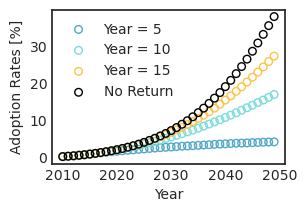

In [6]:
people_per_node = 5
year = 100; interval=2; r_set = [1]
cs = ['#51a8c6', '#7adcdc', '#ffc249', '#ea840c']
fig = plt.figure(figsize=(3,2))
axs = fig.add_subplot()

i = 0
for return_year in [5,10,15]:
    for return_prob in [0.5]:
        func_name = 'ice'+'_'+str(1)+'_'+str(5)+'_'+str(return_prob)+'_'+str(return_year)
        curve_abms, tract_abms = fit_result(state,county,func_name)
        plt.scatter(range(2010,2050),curve_abms[0][:40]*100, label='Year = '+str(return_year),s=30, facecolors='none', edgecolors=cs[i])
        i += 1

func_name = 'ice'+'_'+str(1)+'_'+str(5)+'_'+str(0)+'_'+str(100)
curve_abms, tract_abms = fit_result(state,county,func_name)
plt.scatter(range(2010,2050),curve_abms[0][:40]*100, label='No Return', s=30, facecolors='none', edgecolors='k')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Adoption Rates [%]')
plt.savefig(os.path.join('..', 'figure', state, 'si_ice_year.pdf'),dpi=300,bbox_inches='tight')

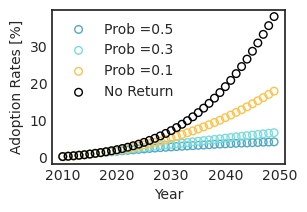

In [7]:
people_per_node = 5
year = 100; interval=2; r_set = [1]
cs = ['#51a8c6', '#7adcdc', '#ffc249', '#ea840c']
fig = plt.figure(figsize=(3,2))
axs = fig.add_subplot()

i = 0
for return_year in [5]:
    for return_prob in [0.5,0.3,0.1]:
        func_name = 'ice'+'_'+str(1)+'_'+str(5)+'_'+str(return_prob)+'_'+str(return_year)
        curve_abms, tract_abms = fit_result(state,county,func_name)
        plt.scatter(range(2010,2050),curve_abms[0][:40]*100, label='Prob ='+str(return_prob),s=30, facecolors='none', edgecolors=cs[i])
        i += 1

func_name = 'ice'+'_'+str(1)+'_'+str(5)+'_'+str(0)+'_'+str(100)
curve_abms, tract_abms = fit_result(state,county,func_name)
plt.scatter(range(2010,2050),curve_abms[0][:40]*100, label='No Return', s=30, facecolors='none', edgecolors='k')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Adoption Rates [%]')
plt.savefig(os.path.join('..', 'figure', state, 'si_ice_prob.pdf'),dpi=300,bbox_inches='tight')

2. Note S5: Urban Layout and Diffusion Process

In [8]:
def visMoranCounty(state,county):
    year = 42; rep_num = 10; interval = 5
    if state == 'wa':
        tract_shp = gpd.read_file(os.path.join('..','data',state,'tract','tl_2020_53_tract.shp'))
    else:
        tract_shp = gpd.read_file(os.path.join('..','data',state,'tract','tl_2019_06_tract.shp'))
    demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
    number_node = int(demo.POPULATION.sum()/5)
    scale = number_node/demo.POPULATION.sum()
    emp_curve = pd.read_csv(os.path.join( '..', 'data', state, county, 'tract_curve.csv'),converters={'tract': str})
    emp_curve = pd.pivot_table(emp_curve, values='cum_reg', index=['tract'], columns=['year'], aggfunc="sum", fill_value=0).reset_index()
    emp_curve = emp_curve[range(13)].sum(axis=0)/demo.POPULATION.sum()
    rexps = [1,3,10]
    sname = ''.join(i.lower() for i  in county.split())

    emp_names = []; de_names = []; ds_names = []
    for i in range(1,13):
        emp_names.append('EMP_'+str(i))

    for i in range(1,year,interval):
        de_names.append('DE_'+str(i))
        ds_names.append('DS_'+str(i))

    data_emp = pd.read_csv(os.path.join( '..', 'data', state, state+'_data.csv'),converters={'GEOID': str})
    data_emp = data_emp.drop_duplicates(subset=['GEOID','CLASS'])
    data_emp = pd.pivot_table(data_emp, values=emp_names+de_names+ds_names+['POPULATION'], index=['GEOID','COUNTY'], aggfunc="mean", fill_value=0).reset_index()
    db = tract_shp.merge(data_emp,right_on='GEOID',left_on='GEOID',how='left').fillna(0)

    population = demo.POPULATION.sum()
    moran_emp = []; moran_de = []; moran_ds = []
    db = gpd.GeoDataFrame(db, crs=db.crs).to_crs(epsg=3857)
    db = db[(db['COUNTY']==county)]
    db.loc[(db['POPULATION'] == 0) | (db['POPULATION']<db['EMP_12']), ['POPULATION']] = 1e10
    w = weights.KNN.from_dataframe(db, k=8); w.transform = "R"
    for year_idx in range(1,13):
        moran_emp.append(esda.moran.Moran((db['EMP_'+str(year_idx)]/db['POPULATION']).clip(0, 1), w).I)      
    moran_emp = np.array(moran_emp)

    for year_idx in range(1,year,interval):
        moran_de.append(esda.moran.Moran((db['DE_'+str(year_idx)]/db['POPULATION']).clip(0,1), w).I)
        moran_ds.append(esda.moran.Moran((db['DS_'+str(year_idx)]/db['POPULATION']).clip(0,1), w).I)
    moran_de = np.array(moran_de); moran_ds = np.array(moran_ds)

    moran_abms = []; moran_abms5 = []; moran_abms95 = []
    adoption_rate_abms = []

    moran_scatter = []; adoption_scatter=[]; r_scatter = []
    for r in rexps:
        moran_abm = []; adoption_rate_abm=[]
        for rep in range(rep_num):
            folder = 'fit_pq_'+sname+'_'+str(0)+'_'+str(number_node)+'_'+str(-1)+'_'+str(r)+'_'+str(3)+'_'+str(3)
            sub_tract = (pd.read_csv(os.path.join('..','result',state, county, folder, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0).cumsum(axis=0).transpose()/scale).reset_index().rename(columns={"index": "GEOID"})
            db = tract_shp.merge(sub_tract,right_on='GEOID',left_on='GEOID',how='left').fillna(0).merge(demo,right_on='GEOID',left_on='GEOID',how='left')
            db = db[(db['COUNTY']==county)]
            db = gpd.GeoDataFrame(db, crs=db.crs).to_crs(epsg=3857)
            w = weights.KNN.from_dataframe(db, k=8); w.transform = "R"
            moran_year = []; adoption_rate_year = []
            for end in range(1,year,interval):
                db['rate'] = (db[end]/db['POPULATION']).fillna(np.mean(db[end]/db['POPULATION'])).clip(0,1)
                mv = esda.moran.Moran(db['rate'], w).I
                av = db[end].sum()/population
                moran_year.append(mv)
                adoption_rate_year.append(av)

                adoption_scatter.append(av)
                moran_scatter.append(mv)
                r_scatter.append(r)
            
            adoption_rate_abm.append(adoption_rate_year)
            moran_abm.append(moran_year)
            
        adoption_rate_abms.append(np.percentile(np.array(adoption_rate_abm),50,axis=0))
        moran_abms.append(np.percentile(np.array(moran_abm),50,axis=0))
        moran_abms5.append(np.percentile(np.array(moran_abm),0,axis=0))
        moran_abms95.append(np.percentile(np.array(moran_abm),100,axis=0))
        
    cl = ['blue', '#81dbed', 'orange']
    fig = plt.figure(figsize=(3.5,2))
    axs = fig.add_subplot()

    plt.plot(np.arange(2011,2011+year,interval),moran_de, color = 'lightgrey', marker='*', markersize = 13, linewidth=2, linestyle='dashed', label='County')
    plt.plot(np.arange(2011,2011+year,interval),moran_ds, color = 'lightgrey',  marker='x', markersize = 10,linewidth=2, linestyle='dashed',label='State')
    plt.scatter(range(2011,2023,2),moran_emp[::2], color = 'grey', marker='s', label='Data',s = 55, zorder=10)
    plt.axvline(2022, color="grey", dashes=(2, 2),linewidth=2)

    for r,i in zip(rexps,range(len(rexps))):
        plt.plot(np.arange(2011,2011+year,interval), moran_abms[i], c = cl[i],marker='o', markersize = 8, linewidth=2, label='$\gamma$ ='+str(r))

    plt.title(county)
    plt.legend(ncol=1, bbox_to_anchor=[1, 1])
    plt.xlabel('Year')
    plt.ylabel('Moran\'s I')
    plt.savefig(os.path.join('..', 'figure', state, county, 'future_curve_moran.pdf'),dpi=300,bbox_inches='tight')
    plt.show()

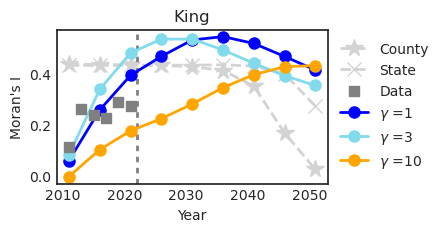

In [9]:
state = 'wa'; county = 'King'
visMoranCounty(state,county)

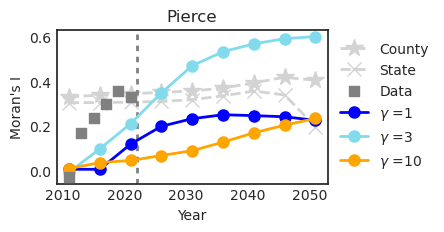

In [10]:
state = 'wa'; county = 'Pierce'
visMoranCounty(state,county)

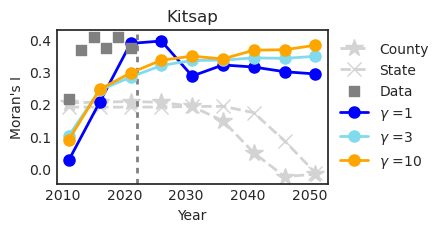

In [11]:
state = 'wa'; county = 'Kitsap'
visMoranCounty(state,county)

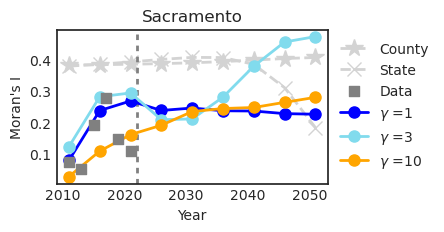

In [12]:
state = 'ca'; county = 'Sacramento'
visMoranCounty(state,county)

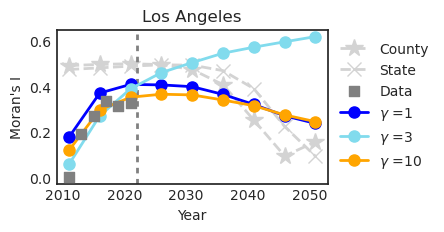

In [13]:
state = 'ca'; county = 'Los Angeles'
visMoranCounty(state,county)

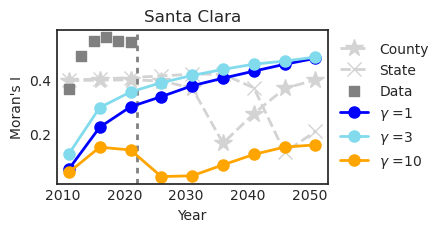

In [14]:
state = 'ca'; county = 'Santa Clara'
visMoranCounty(state,county)

3. Note S6: Justification of Market Segmentation

In [15]:
def visStateCorr(state):
    house = pd.read_csv(os.path.join('..','data',state, 'house/ACSDP5Y2022.DP04-Data.csv'),skiprows=1)
    education = pd.read_csv(os.path.join('..','data',state, 'education/ACSST5Y2022.S1501-Data.csv'),skiprows=1)
    income = pd.read_csv(os.path.join('..','data',state, 'income/ACSST5Y2019.S1901-Data.csv'),skiprows=1)

    income_name = ["Geography",
    "Estimate!!Households!!Median income (dollars)"]

    education_name = ["Geography",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over",
    "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"]

    house_name = ["Geography",
    "Estimate!!UNITS IN STRUCTURE!!Total housing units",
    "Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached",
    "Estimate!!HOUSING TENURE!!Occupied housing units",
    "Estimate!!HOUSING TENURE!!Occupied housing units!!Owner-occupied",
    "Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of owner-occupied unit"]

    income.loc[income["Estimate!!Households!!Median income (dollars)"]=='-', "Estimate!!Households!!Median income (dollars)"] = np.nan
    income.loc[income["Estimate!!Households!!Median income (dollars)"]=='250,000+', "Estimate!!Households!!Median income (dollars)"] = 250000
    income['income'] = income["Estimate!!Households!!Median income (dollars)"].astype(float)/250000

    education['rate_edu'] = education["Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"]/education["Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over"]
    house['rate_sfh'] = house["Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached"]/house["Estimate!!UNITS IN STRUCTURE!!Total housing units"]
    house['rate_own'] = house["Estimate!!HOUSING TENURE!!Occupied housing units!!Owner-occupied"]/house["Estimate!!HOUSING TENURE!!Occupied housing units"]
    name = ['income','rate_sfh','rate_edu','rate_own']

    data = income.merge(education,right_on='Geography',left_on='Geography').merge(house,right_on='Geography',left_on='Geography')[name]
    return data

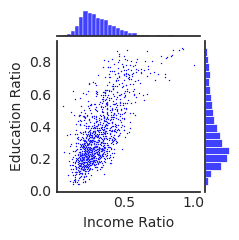

In [16]:
state = 'wa'
data = visStateCorr(state)
g = sns.jointplot(
    x="income", y="rate_edu", data=data,
    color='blue', height=2.5, s=1
)
plt.xlabel('Income Ratio')
plt.ylabel('Education Ratio')
plt.savefig(os.path.join('..', 'figure', state, 'income_edu.jpg'),dpi=300,bbox_inches='tight')

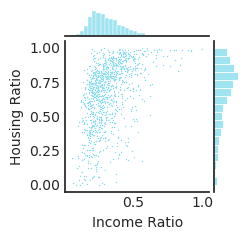

In [17]:
g = sns.jointplot(
    x="income", y="rate_sfh", data=data,
    color='#81dbed', height=2.5, s=1
)
plt.xlabel('Income Ratio')
plt.ylabel('Housing Ratio')
plt.savefig(os.path.join('..', 'figure', state, 'income_sfh.jpg'),dpi=300,bbox_inches='tight')

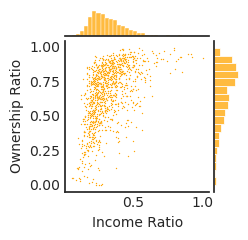

In [18]:
g = sns.jointplot(
    x="income", y="rate_own", data=data,
    color='orange', height=2.5, s=1
)
plt.xlabel('Income Ratio')
plt.ylabel('Ownership Ratio')
plt.savefig(os.path.join('..', 'figure', state, 'income_own.jpg'),dpi=300,bbox_inches='tight')

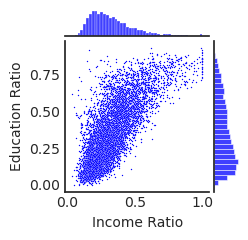

In [19]:
state = 'ca'
data = visStateCorr(state)
g = sns.jointplot(
    x="income", y="rate_edu", data=data,
    color='blue', height=2.5, s=1
)
plt.xlabel('Income Ratio')
plt.ylabel('Education Ratio')
plt.savefig(os.path.join('..', 'figure', state, 'income_edu.jpg'),dpi=300,bbox_inches='tight')

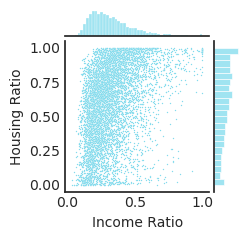

In [20]:
g = sns.jointplot(
    x="income", y="rate_sfh", data=data,
    color='#81dbed', height=2.5, s=1
)
plt.xlabel('Income Ratio')
plt.ylabel('Housing Ratio')
plt.savefig(os.path.join('..', 'figure', state, 'income_sfh.jpg'),dpi=300,bbox_inches='tight')

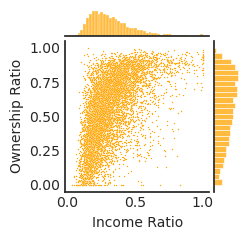

In [21]:
g = sns.jointplot(
    x="income", y="rate_own", data=data,
    color='orange', height=2.5, s=1
)
plt.xlabel('Income Ratio')
plt.ylabel('Ownership Ratio')
plt.savefig(os.path.join('..', 'figure', state, 'income_own.jpg'),dpi=300,bbox_inches='tight')

4. Note S7: Sensitivity Analysis on Network Size

4.1 Moran Index

In [22]:
def network_statistic(state,county,r,people_per_node):
    demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
    population = demo['POPULATION'].sum()
    n = int(population/people_per_node)
    edge_list = np.load(os.path.realpath(os.path.join( '..', 'result', state, county, 'edge_list_'+str(n)+'_-1_'+str(r)+'_3_3.npy')))

    NNODE = len(np.unique(edge_list))
    NEDGE = len(edge_list)
    C = np.load(os.path.realpath(os.path.join( '..', 'result', state, county, 'C_'+str(n)+'_-1_'+str(r)+'_3_3.npy')))
    H = np.load(os.path.realpath(os.path.join( '..', 'result', state, county, 'H_'+str(n)+'_-1_'+str(r)+'_3_3.npy')))
    K_T = np.load(os.path.realpath(os.path.join( '..', 'result', state, county, 'K_'+str(n)+'_-1_'+str(r)+'_3_3.npy')))
    PKF = powerlaw.Fit(K_T,xmin=1,xmax=100).alpha
    R_T = np.load(os.path.realpath(os.path.join( '..', 'result', state, county, 'R_'+str(n)+'_-1_'+str(r)+'_3_3.npy')))
    PRF  = powerlaw.Fit(R_T, xmin=1,xmax=100).alpha
    return NNODE,NEDGE,np.round(np.mean(K_T),4),np.round(np.mean(R_T),4),np.round(np.mean(C),4),np.round(np.mean(H),4),np.round(PKF,4),np.round(PRF,4)

def genToy(gamma, people_per_node, county, pq):
    n_rep = 5; year = 100
    DATA_PATH = os.path.join('..', 'data', state)
    
    func_name = 'sens'+'_'+str(gamma)+'_'+str(people_per_node)
    RESULT_PATH = os.path.join('..', 'result', state, county, func_name)
    if not os.path.exists(os.path.join(RESULT_PATH, 'curves')):
        os.makedirs(os.path.join(RESULT_PATH, 'curves'))

    demo = pd.read_csv(os.path.join(DATA_PATH, county, 'demo_data.csv'))
    tract_shp = gpd.read_file(os.path.join(DATA_PATH, 'tract','tl_2019_06_tract.shp'))
    
    number_node = int(demo.POPULATION.sum()/people_per_node); par = [-1, gamma, 3, 3, 0, 13,'None']
    G = NetworkCreators(0,par+[number_node,state,county])
    G.build_network()

    for j in range(n_rep):
        simulation_paras = {"p_value": pq['p'],
                            "q_value": pq['q']}
        simulation = SimulateParameter(G, simulation_paras, 0, year, state, county)
        simulation.run()
        state_curve = simulation.output_curve_by_state()
        tract_curve = simulation.output_curve_by_tract()
        agent_curve = simulation.output_curve_by_agent()
        G.reset()

        with open(os.path.join(RESULT_PATH,  'curves', 'state_curve_'+str(j)+'.pkl'), "wb") as f:
            pickle.dump(state_curve, f)
        tract_curve.to_csv(os.path.join(RESULT_PATH, 'curves', 'tract_curve_'+str(j)+'.csv'))
        agent_curve.to_csv(os.path.join(RESULT_PATH, 'curves', 'agent_curve_'+str(j)+'.csv'))

def visMoranToy(r):
    peoplelist=[5,10,25,100]; rep_num = 5; year = 100; interval = 2
    cl = ['blue', '#81dbed', '#ffc249', '#ea840c']
    name = 'sens'

    fig = plt.figure(figsize=(2.5,2))
    axs = fig.add_subplot()
    for people_per_node,i in zip(peoplelist,range(len(peoplelist))):
        number_node = int(pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str}).POPULATION.sum()/people_per_node)
        scale = number_node/demo.POPULATION.sum()
        moran_abms = []; moran_abms5 = []; moran_abms95 = []
        adoption_rate_abms = []

        moran_scatter = []; adoption_scatter=[]; r_scatter = []
        moran_abm = []; adoption_rate_abm=[]

        for rep in range(rep_num):
            folder = name+'_'+str(r)+'_'+str(people_per_node)
            sub_tract = (pd.read_csv(os.path.join('..','result',state, county, folder, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0).cumsum(axis=0).transpose()/scale).reset_index().rename(columns={"index": "GEOID"})
            db = tract_shp.merge(sub_tract,right_on='GEOID',left_on='GEOID',how='left').fillna(0).merge(demo,right_on='GEOID',left_on='GEOID',how='left')
            db = db[(db['COUNTY']==county)]
            db = gpd.GeoDataFrame(db, crs=db.crs).to_crs(epsg=3857)
            w = weights.KNN.from_dataframe(db, k=8); w.transform = "R"
            moran_year = []; adoption_rate_year = []
            for end in range(1,year,interval):
                db['rate'] = (db[end]/db['POPULATION']).fillna(np.mean(db[end]/db['POPULATION'])).clip(0,1)
                mv = esda.moran.Moran(db['rate'], w).I
                av = db[end].sum()/population
                moran_year.append(mv)
                adoption_rate_year.append(av)
                
            adoption_rate_abm.append(adoption_rate_year)
            moran_abm.append(moran_year)
            
        adoption_rate_abms.append(np.percentile(np.array(adoption_rate_abm),50,axis=0)*100)
        moran_abms.append(np.percentile(np.array(moran_abm),50,axis=0))
        plt.scatter(adoption_rate_abms[0],moran_abms[0],label='Expansion Factor ='+str(people_per_node),s=30, facecolors='none', edgecolors=cl[i])

    plt.title('$\gamma=$'+str(r))
    plt.xlabel('Adoption Rates [%]')
    plt.ylabel('Moran\'s I')
    plt.savefig(os.path.join('..', 'figure', state, 'si_moran_r'+str(r)+'.pdf'),dpi=300,bbox_inches='tight')
    plt.show()

In [23]:
county = 'Los Angeles'; state = 'ca'
demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
tract_shp = gpd.read_file(os.path.join('..','data',state,'tract','tl_2019_06_tract.shp'))
population = demo.POPULATION.sum()

func_name = 'fit_pq_losangeles_'+str(0)+'_'+str(int(population/25))+'_'+str(-1)+'_'+str(3)+'_'+str(3)+'_'+str(3)
RESULT_PATH = os.path.join('..', 'result', state, county, func_name)
with open(os.path.join(RESULT_PATH, 'parameters', 'p_value_star.pkl'), "rb") as f:
    p_value_star = pickle.load(f)
with open(os.path.join(RESULT_PATH, 'parameters', 'q_value_star.pkl'), "rb") as f:
    q_value_star = pickle.load(f)
pq = {'p':{0:p_value_star[0], 1:p_value_star[1], 2:p_value_star[2]},
      'q':{0:q_value_star[0], 1:q_value_star[1], 2:q_value_star[2]}}

# genToy(1, 100, county, pq)
# genToy(3, 100, county, pq)
# genToy(10, 100, county, pq)

In [24]:
emp_names = []
for i in range(1,13):
    emp_names.append('EMP_'+str(i))
    
data_emp = pd.read_csv(os.path.join( '..', 'data', state, state+'_data.csv'),converters={'GEOID': str})
data_emp = data_emp.drop_duplicates(subset=['GEOID','CLASS'])
data_emp = pd.pivot_table(data_emp, values=emp_names+['POPULATION'], index=['GEOID','COUNTY'], aggfunc="mean", fill_value=0).reset_index()
db = tract_shp.merge(data_emp,right_on='GEOID',left_on='GEOID',how='left').fillna(0)

moran_emp = []; rate_emp = []
db = gpd.GeoDataFrame(db, crs=db.crs).to_crs(epsg=3857)
db = db[(db['COUNTY']==county)]
db.loc[(db['POPULATION'] == 0) | (db['POPULATION']<db['EMP_12']), ['POPULATION']] = 1e10
w = weights.KNN.from_dataframe(db, k=8); w.transform = "R"
for year_idx in range(1,13):
    rate_emp.append(db['EMP_'+str(year_idx)].sum()/population)
    moran_emp.append(esda.moran.Moran((db['EMP_'+str(year_idx)]/db['POPULATION']).clip(0,1), w).I)      
moran_emp = np.array(moran_emp)
rate_emp = np.array(rate_emp)

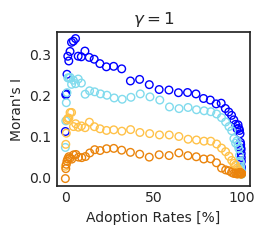

In [25]:
visMoranToy(1)

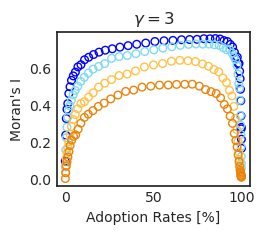

In [26]:
visMoranToy(3)

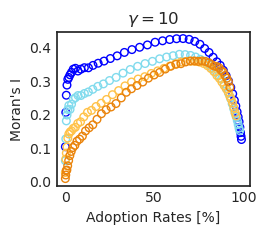

In [27]:
visMoranToy(10)

4.2 Adoption Curve

In [34]:
def fitResult(state,county,people_per_node,r_set,year,interval):
    n_batch = 1; n_rep = 5
    demo = pd.read_csv(os.path.realpath(os.path.join('..', 'data', state, county, 'demo_data.csv')),converters={'GEOID': str})
    population = demo['POPULATION'].sum()
    n = int(population/people_per_node)

    tract_abms = []; curve_abms = []
    for r in r_set:
        tract_abm = []; curve_abm = []
        for batch in range(n_batch):
            for rep in range(n_rep):
                folder = 'sens'+'_'+str(r)+'_'+str(people_per_node)
                sims = pd.read_csv(os.path.join('..','result',state, county, folder, 'curves', 'tract_curve_'+str(rep)+'.csv'),index_col=0)
                tract_abm.append((sims.cumsum(axis=0).transpose()*people_per_node)[range(year)])
                curve_abm.append((sims.cumsum(axis=0).transpose()*people_per_node).sum(axis=0)[range(year)].values/demo.POPULATION.sum())
        
        data = pd.concat(tract_abm).reset_index()
        data = pd.pivot_table(data,index='index',aggfunc="mean").merge(demo, left_on='index', right_on='GEOID')
        data = data[list(range(year))+['POPULATION','GEOID','CLASS']]
        for i in range(year):  # From column 1 to 7
            data = data.rename(columns={i: f'ABM_{i}'})
        
        tract_abms.append(data)
        curve_abms.append(np.percentile(np.array(curve_abm),50, axis = 0))
    
    return curve_abms, tract_abms

def visCurveCounty(r):
    cl = ['blue', '#81dbed', '#ffc249', '#ea840c']
    people_per_node = 5; year = 100; interval=2; r_set = [r]
    peoplelist = [5,10,25,100]

    fig = plt.figure(figsize=(2.5,2))
    axs = fig.add_subplot()
    for people_per_node,i in zip(peoplelist,range(len(peoplelist))):
        curve_abms, tract_abms = fitResult(state,county,people_per_node,r_set,year,interval)
        plt.scatter(range(2010,2110),curve_abms[0]*100, label='Expansion Factor = '+str(people_per_node),s=30, facecolors='none', edgecolors=cl[i])
    plt.title('$\gamma=$'+str(r_set[0]))
    plt.xlabel('Year')
    plt.ylabel('Adoption Rates [%]')
    plt.savefig(os.path.join('..', 'figure', state, 'si_rate_r1.pdf'),dpi=300,bbox_inches='tight')
    plt.show()
    

In [32]:
state = 'ca'; county = 'Los Angeles'
tract_shp = gpd.read_file(os.path.join('..','data',state,'tract','tl_2019_06_tract.shp'))

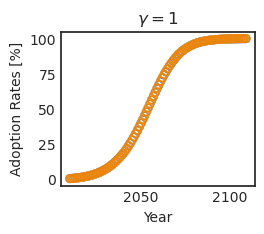

In [35]:
visCurveCounty(1)

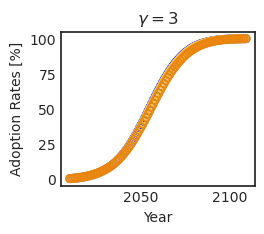

In [36]:
visCurveCounty(3)

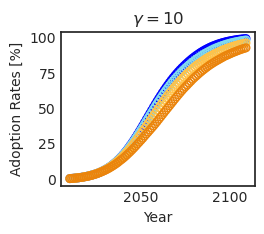

In [37]:
visCurveCounty(10)

5. Note S8: Justification of Values of $ \gamma $

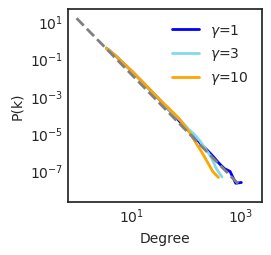

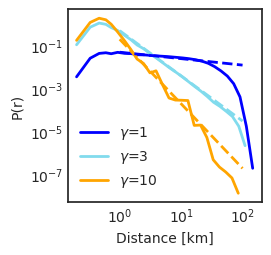

In [38]:
cl = ['blue', '#81dbed', 'orange']
state = 'ca'; county = 'Los Angeles'

count = 0
fig, ax = plt.subplots(figsize=(2.5,2.5))
for r in [1,3,10]:
    K_T = np.load(os.path.realpath(os.path.join( '..', 'result', state, county, 'K_1189165_-1_'+str(r)+'_3_3.npy')))
    powerlaw.plot_pdf(K_T,ax=ax, label='$\gamma$='+str(r), c = cl[count], linewidth=2)
    # results = powerlaw.Fit(K_T,xmin=1,xmax=20)
    # print(results.alpha)
    count = count + 1
x = np.linspace(1, 1000, 10)  # From 1 to 10 with 100 points
y = 15*x**(-3)
plt.plot(x, y, color='grey', linestyle='--', linewidth=2)
plt.legend()
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join('..', 'figure', state, 'si_network_pk.pdf'),dpi=300,bbox_inches='tight')
plt.show()

count = 0
fig, ax = plt.subplots(figsize=(2.5,2.5))
for r in [1,3,10]:
    R_T = np.load(os.path.realpath(os.path.join( '..', 'result', state, county, 'R_1189165_-1_'+str(r)+'_3_3.npy')))
    powerlaw.plot_pdf(R_T,ax=ax, label='$\gamma$='+str(r),c = cl[count], linewidth=2)
    # results = powerlaw.Fit(R_T, xmin=1,xmax=20)
    count = count + 1

x = np.linspace(1, 100, 10)  # From 1 to 10 with 100 points
y = 0.5*x**(-2.1)
plt.plot(x, y, color='#81dbed', linestyle='--', linewidth=2)

y = 0.2*x**(-3.0)
plt.plot(x, y, color="orange", linestyle='--', linewidth=2)

y = 0.05*x**(-0.3)
plt.plot(x, y, color="b", linestyle='--', linewidth=2)

plt.legend()
plt.xlabel('Distance [km]')
plt.ylabel('P(r)')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join('..', 'figure', state, 'si_network_pr.pdf'),dpi=300,bbox_inches='tight')
plt.show()